In [70]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import equinox as eqx
import optax
from jax import random, jit, lax, grad, value_and_grad
from functools import partial

from pathlib import Path
from tqdm import tqdm
from typing import Any, Optional
from dataclasses import dataclass

import time

# Load dataset

In [6]:
def load_idx_images(path):
    with open(path, "rb") as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=">i4")
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num, rows * cols)  # flatten


def load_idx_labels(path):
    with open(path, "rb") as f:
        magic, num = np.frombuffer(f.read(8), dtype=">i4")
        return np.frombuffer(f.read(), dtype=np.uint8)


def load_mnist_from_archive(archive_path='archive'):
    '''
    load the data and normalize it to the [-1,1] range

    '''
    archive_path = Path(archive_path)

    train_images = load_idx_images(archive_path / "train-images.idx3-ubyte")
    train_labels = load_idx_labels(archive_path / "train-labels.idx1-ubyte")

    test_images  = load_idx_images(archive_path / "t10k-images.idx3-ubyte")
    test_labels  = load_idx_labels(archive_path / "t10k-labels.idx1-ubyte")

    N  = 784
    Nc = 10
    Ns  = train_images.shape[0]
    NsT = test_images.shape[0]

    M  = 2 * (train_images / 255.0) - 1
    MT = 2 * (test_images  / 255.0) - 1

    M  = M.T
    MT = MT.T

    Lab  = -np.ones((Nc, Ns))
    LabT = -np.ones((Nc, NsT))

    Lab[train_labels, np.arange(Ns)] = 1.0
    LabT[test_labels, np.arange(NsT)] = 1.0
    
    M = jnp.array(M)
    Lab = jnp.array(Lab)
    MT = jnp.array(MT)
    LabT = jnp.array(LabT)

    return M, Lab, MT, LabT

In [8]:
N=784 
Nc=10 
Ns=60000 
NsT=10000

M, Lab, MT, LabT = load_mnist_from_archive('archive')

# Model

This cell defines parameters of the algorithm: 

`n` - power of the rectified polynomial in Eq 3:
$$
F(x) =  \begin{cases} 
      x^n, & x \geq 0 \\
      0,   & x < 0 
   \end{cases}  \tag{3}
$$

`m` - power of the loss function in Eq 14; 
$$
C = \sum_{\text{training examples}} \sum_{\alpha=1}^{N_c} (c_\alpha - t_\alpha)^{2m} \tag{14}
$$

`K` - number of memories that are displayed as an `Ky` by `Kx` array by the visualization function defined above (used for visualization only); 

`eps0` - initial learning rate that is exponentially annealed during training with the damping parameter `f`, as explained in Eq 12; 
$$
\varepsilon (t) = \varepsilon_0 f^t, f = 0.998 \tag{12}
$$

`p` - momentum as defined in Eq 13; 
$$
V_I^\mu(t) = p V_I^\mu(t-1) - \partial_{\xi_I^\mu} C \\

\xi_I^\mu(t) = \xi_I^\mu(t-1) + \varepsilon \frac{V_I^\mu(t)}{\max\limits_{J}|V_J^\mu(t)|} \tag{13}
$$
`mu` - the mean of the gaussian distribution that initializes the weights;  

`sigma` - the standard deviation of that gaussian;  

`Nep` - number of epochs; 

`Num` - size of the training minibatch; `NumT` - size of the test minibatch; 

`prec` - parameter that controls numerical precision of the weight updates. 

Parameter `beta` that is used in Eq 9 is defined as `beta=1/Temp**n`. 
$$
c_{\alpha} = g \left[
    \beta \sum_{\mu = 1}^K \left(F(-\xi_{\alpha}^{\mu} x_{\alpha} + \sum_{\gamma \neq \alpha}\xi_{\gamma}^{\mu} x_{\gamma} + \sum_{i=1}^N \xi_{i}^{\mu} v_i)   -
    F(\xi_{\alpha}^{\mu} x_{\alpha} + \sum_{\gamma \neq \alpha}\xi_{\gamma}^{\mu} x_{\gamma} + \sum_{i=1}^N \xi_{i}^{\mu} v_i) \right)
\right] \tag{9}
$$

The choice of temperatures `Temp` as well as the duration of the annealing `thresh_pret` is discussed in Appendix A.

In [38]:
@dataclass
class DAMConfig:
    Kx: int = 10
    Ky: int = 10
    n: int = 20
    m: int = 30
    eps0: float = 4.0e-2
    f: float = 0.998
    p: float = 0.6
    Nep: int = 20
    Temp_in: float = 540.
    Temp_f: float = 540.
    thresh_pret: int = 200
    Num: int = 1000
    NumT: int = 5000
    mu: float = -0.3
    sigma: float = 0.3
    prec: float = 1.0e-30
    Nc: int = 10
    N: int = 784

In [ ]:
class DAM:
    def __init__(self, config: DAMConfig, M, Lab, MT, LabT, seed: int = 19):
        self.config = config
        self.M = M
        self.Lab = Lab
        self.MT = MT
        self.LabT = LabT
        self.Ns = M.shape[1]
        self.NsT = MT.shape[1]
        
        K = config.Kx * config.Ky
        self.K = K
        
        self.key = random.PRNGKey(seed)
        self.KS = random.normal(self.key, (K, config.N + config.Nc)) * config.sigma + config.mu
        self.VKS = jnp.zeros((K, config.N + config.Nc))
        
        self.aux = -jnp.ones((config.Nc, config.Num * config.Nc))
        for d in range(config.Nc):
            self.aux = self.aux.at[d, d*config.Num:(d+1)*config.Num].set(1.)
        
        self.auxT = -jnp.ones((config.Nc, config.NumT * config.Nc))
        for d in range(config.Nc):
            self.auxT = self.auxT.at[d, d*config.NumT:(d+1)*config.NumT].set(1.)
        
        self.err_tr = []
        self.err_test = []
        self.current_epoch = 0

    def save_checkpoint(self, path: str):
        checkpoint = {
            'KS': np.array(self.KS),
            'VKS': np.array(self.VKS),
            'key': self.key,
            'err_tr': self.err_tr,
            'err_test': self.err_test,
            'current_epoch': self.current_epoch,
            'config': self.config
        }
        os.makedirs(os.path.dirname(path) if os.path.dirname(path) else '.', exist_ok=True)
        with open(path, 'wb') as f:
            pickle.dump(checkpoint, f)

    def load_checkpoint(self, path: str):
        with open(path, 'rb') as f:
            checkpoint = pickle.load(f)
        self.KS = jnp.array(checkpoint['KS'])
        self.VKS = jnp.array(checkpoint['VKS'])
        self.key = checkpoint['key']
        self.err_tr = checkpoint['err_tr']
        self.err_test = checkpoint['err_test']
        self.current_epoch = checkpoint['current_epoch']

In [40]:
@partial(jit, static_argnums=(7, 8, 9, 10, 11, 12))
def training_step(KS, VKS, v, t_R, aux, beta, eps, p, prec, n, m, Nc, Num):
    t = jnp.reshape(t_R, (1, Nc * Num))
    
    u = jnp.concatenate((v, -jnp.ones((Nc, Num))), axis=0)
    uu = jnp.tile(u, (1, Nc))
    vv = jnp.concatenate((uu[:N, :], aux), axis=0)
    
    KSvv = jnp.maximum(jnp.dot(KS, vv), 0)
    KSuu = jnp.maximum(jnp.dot(KS, uu), 0)
    
    Y = jnp.tanh(beta * jnp.sum(KSvv**n - KSuu**n, axis=0))
    Y_R = jnp.reshape(Y, (Nc, Num))
    
    K = 10 * 10 #Kx*Ky
    # gradients of the loss function
    factor = (t - Y)**(2*m - 1) * (1 - Y) * (1 + Y)
    d_KS = (jnp.dot(jnp.tile(factor, (K, 1)) * KSvv**(n-1), vv.T) - 
            jnp.dot(jnp.tile(factor, (K, 1)) * KSuu**(n-1), uu.T))
    
    VKS_new = p * VKS + d_KS
    nc = jnp.max(jnp.abs(VKS_new), axis=1, keepdims=True)
    nc = jnp.where(nc < prec, prec, nc)
    ncc = jnp.tile(nc, (1, N + Nc))
    KS_new = KS + eps * VKS_new / ncc
    KS_new = jnp.clip(KS_new, -1., 1.)
    
    correct = jnp.argmax(Y_R, axis=0) == jnp.argmax(t_R, axis=0)
    num_correct = jnp.sum(correct)
    
    return KS_new, VKS_new, num_correct

# test step
@partial(jit, static_argnums=(4, 5, 6, 7))
def test_step(KS, v, t_R, auxT, beta, n, Nc, NumT):
    u = jnp.concatenate((v, -jnp.ones((Nc, NumT))), axis=0)
    uu = jnp.tile(u, (1, Nc))
    vv = jnp.concatenate((uu[:N, :], auxT), axis=0)
    
    KSvv = jnp.maximum(jnp.dot(KS, vv), 0)
    KSuu = jnp.maximum(jnp.dot(KS, uu), 0)
    
    Y = jnp.tanh(beta * jnp.sum(KSvv**n - KSuu**n, axis=0))
    Y_R = jnp.reshape(Y, (Nc, NumT))
    
    correct = jnp.argmax(Y_R, axis=0) == jnp.argmax(t_R, axis=0)
    return jnp.sum(correct)



def train(model: DAM, 
          checkpoint_dir: Optional[str] = None, 
          checkpoint_every: Optional[int] = None):
        cfg = model.config
        
        for nep in tqdm(range(model.current_epoch, cfg.Nep)):
            eps = cfg.eps0 * cfg.f ** nep
            
            if nep <= cfg.thresh_pret:
                Temp = cfg.Temp_in + (cfg.Temp_f - cfg.Temp_in) * nep / cfg.thresh_pret
            else:
                Temp = cfg.Temp_f
            beta = 1.0 / Temp ** cfg.n

            model.key, subkey = random.split(model.key)
            perm = random.permutation(subkey, model.Ns)
            M_shuffled = model.M[:, perm]
            Lab_shuffled = model.Lab[:, perm]
            
            total_correct = 0
            for k in range(model.Ns // cfg.Num):
                v = M_shuffled[:, k*cfg.Num:(k+1)*cfg.Num]
                t_R = Lab_shuffled[:, k*cfg.Num:(k+1)*cfg.Num]
                
                model.KS, model.VKS, num_correct = training_step(
                    model.KS, model.VKS, v, t_R, model.aux, beta, eps,
                    cfg.p, cfg.prec, cfg.n, cfg.m, cfg.Nc, cfg.Num
                )
                total_correct += num_correct
            
            model.err_tr.append(100.0 * (1.0 - total_correct / model.Ns))
            
            total_correct_test = 0
            for k in range(model.NsT // cfg.NumT):
                v = model.MT[:, k*cfg.NumT:(k+1)*cfg.NumT]
                t_R = model.LabT[:, k*cfg.NumT:(k+1)*cfg.NumT]
                
                num_correct = test_step(
                    model.KS, v, t_R, model.auxT, beta, cfg.n, cfg.Nc, cfg.NumT
                )
                total_correct_test += num_correct
            
            model.err_test.append(100.0 * (1.0 - total_correct_test / model.NsT))
            model.current_epoch = nep + 1
            
            if checkpoint_dir and checkpoint_every and (nep + 1) % checkpoint_every == 0:
                ckpt_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{nep + 1}.pkl')
                model.save_checkpoint(ckpt_path)
        
        return model.KS, model.err_tr, model.err_test

# Visualization

In [23]:
def draw_heatmap(synapses, Kx, Ky, fig=None, title=None):

    if fig is None:
        fig = plt.figure(figsize=(6, 6))
    fig.clf()
    ax = fig.add_subplot(111)

    syn_np = np.array(synapses)
    syn_np = np.nan_to_num(syn_np, nan=0.0, posinf=0.0, neginf=0.0)

    K = syn_np.shape[0]
    expected_K = Kx * Ky
    if K != expected_K:
         raise ValueError(f"draw_heatmap: expected K={expected_K} (=Kx*Ky) but got K={K}")

    HM = np.zeros((28 * Ky, 28 * Kx))
    yy = 0
    for y in range(Ky):
        for x in range(Kx):
            patch = syn_np[yy, :].reshape(28, 28)
            patch = np.nan_to_num(patch, nan=0.0, posinf=0.0, neginf=0.0)
            HM[y * 28:(y + 1) * 28, x * 28:(x + 1) * 28] = patch
            yy += 1

    if np.all(HM == 0):
        vmin, vmax = -1.0, 1.0
    else:
        nm = np.nanmax(np.abs(HM))
        vmin, vmax = (-nm, nm) if nm != 0 else (-1.0, 1.0)

    im = ax.imshow(HM, cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, ticks=[np.nanmin(HM), 0, np.nanmax(HM)])
    ax.axis('off')
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()
    return fig

In [24]:
def plot_errors(err_tr, err_test, fig=None, save_path=None):
    if fig is None:
        fig = plt.figure(figsize=(8, 5))
    fig.clf()
    ax = fig.add_subplot(111)

    err_tr_np = np.array(err_tr)
    err_test_np = np.array(err_test)

    epochs_tr = np.arange(1, len(err_tr_np) + 1)
    epochs_test = np.arange(1, len(err_test_np) + 1)

    ax.plot(epochs_tr, err_tr_np, label='train', linewidth=2)
    ax.plot(epochs_test, err_test_np, label='test', linewidth=2)

    ax.set_xlabel('number of epochs')
    ax.set_ylabel('error (%)')
    ax.set_ylim(0, 100)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    # plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=200)

    plt.show()
    return fig

# Training

In [41]:
config = DAMConfig(Nep=300)
model = DAM(config, M, Lab, MT, LabT, seed=19)

In [43]:
KS, err_tr, err_test = train(model, checkpoint_dir='checkpoints', checkpoint_every=10)

100%|██████████| 300/300 [00:40<00:00,  7.47it/s]


In [44]:
model.save_checkpoint('my_checkpoint.pkl')

In [ ]:
# trainer.save_checkpoint('my_checkpoint.pkl')
# trainer.load_checkpoint('my_checkpoint.pkl')

# Adversarial Attacks

In [51]:
# @jit
def predict_raw_scores(KS, x, beta, n, Nc):
    """
    Compute the model's raw per-class scores for a single feature vector x.
    x: shape (N,) (values in [-1, 1])
    Returns: shape (Nc,) raw outputs (the Y values after tanh)
    """
    # make x shape (N,1)
    v = jnp.reshape(x, (x.shape[0], 1))   # (N, 1)
    # create the u vector with label placeholders (same as in test_step)
    u = jnp.concatenate((v, -jnp.ones((Nc, 1))), axis=0)  # (N+Nc, 1)
    uu = jnp.tile(u, (1, Nc))   # (N+Nc, Nc)
    # build aux for NumT=1: aux_single shape (Nc, Nc) with 1 block per class
    aux_single = -jnp.ones((Nc, Nc))
    for d in range(Nc):
        aux_single = aux_single.at[d, d].set(1.0)
    vv = jnp.concatenate((uu[:x.shape[0], :], aux_single), axis=0)  # (N+Nc, Nc)
    KSvv = jnp.maximum(jnp.dot(KS, vv), 0.0)
    KSuu = jnp.maximum(jnp.dot(KS, uu), 0.0)
    Y = jnp.tanh(beta * jnp.sum(KSvv**n - KSuu**n, axis=0))  # length Nc
    return Y  # shape (Nc,)

# @jit
def predict_label(KS, x, beta, n, Nc):
    scores = predict_raw_scores(KS, x, beta, n, Nc)
    return jnp.argmax(scores), scores

In [52]:

def pgd_linf_attack(
    KS,
    x_orig,                   # original input, shape (N,), values in [-1,1]
    true_label,               # integer label (0..Nc-1)
    eps=0.11,                 # l_infty bound (same scale as your inputs)
    alpha=0.01,               # step size per iteration (l_infty step)
    steps=200,                # number of PGD steps
    random_start=True,        # random init inside l_inf ball
    beta=None,                # beta for model; if None use model-like default
    n=None,
    Nc=None
):
    """
    Returns: adversarial example x_adv (shape (N,)), and history of predicted labels if desired.
    """
    # ensure arrays
    x_orig = jnp.array(x_orig)
    KS = jnp.array(KS)

    if beta is None or n is None or Nc is None:
        raise ValueError("Provide beta, n, Nc from your model config for consistent behaviour.")

    key = jax.random.PRNGKey(0)

    # initialize delta
    if random_start:
        key, subk = jax.random.split(key)
        delta = jax.random.uniform(subk, shape=x_orig.shape, minval=-eps, maxval=eps)
    else:
        delta = jnp.zeros_like(x_orig)

    # loss to maximize: cross-entropy (negative log-prob of true class),
    # computed from raw scores Y (which are in [-1,1], but softmax still works).
    def loss_fn(delta_local):
        x_pert = x_orig + delta_local
        scores = predict_raw_scores(KS, x_pert, beta, n, Nc)  # shape (Nc,)
        # use log-softmax to compute CE
        logp = jax.nn.log_softmax(scores)
        return -logp[true_label]   # we maximize this loss (make true class unlikely)

    # gradient function wrt delta
    grad_fn = jit(grad(loss_fn))

    # PGD loop (we'll do simple sign-step for l_inf)
    delta = jnp.clip(delta, -eps, eps)
    for i in range(steps):
        g = grad_fn(delta)
        # l_inf step: move along sign of gradient
        delta = delta + alpha * jnp.sign(g)
        # project back to l_inf ball and also keep valid input range [-1,1]
        delta = jnp.clip(delta, -eps, eps)
        x_adv = jnp.clip(x_orig + delta, -1.0, 1.0)
        delta = x_adv - x_orig

    x_adv = jnp.clip(x_orig + delta, -1.0, 1.0)
    return x_adv

In [ ]:
idx = 0

cfg = model.config
n = cfg.n
Nc = cfg.Nc

# choose a beta consistent with testing: (train used beta = 1/Temp**n)
# Use final Temp_f as evaluation temperature
Temp = cfg.Temp_f
beta = 1.0 / (Temp ** cfg.n)

# original sample and true label
x0 = model.MT[:, idx]         # shape (N,) in [-1,1]
true_label = int(jnp.argmax(model.LabT[:, idx]))

# print original prediction
pred_before, scores_before = predict_label(model.KS, x0, beta, n, Nc)
print("Before attack: predicted =", int(pred_before), "true =", int(true_label))

Before attack: predicted = 7 true = 7


After attack: predicted = 7 true = 7


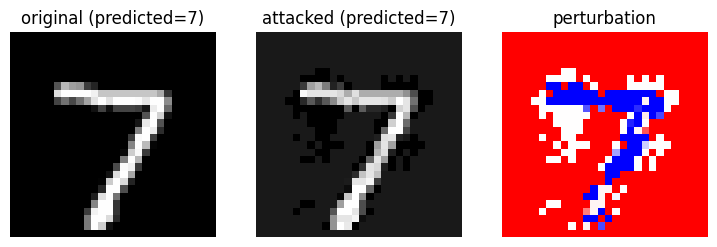

In [65]:
eps = 0.2 
alpha = 10
steps = 50

x_adv = pgd_linf_attack(
    model.KS, x0, true_label,
    eps=eps, alpha=alpha, steps=steps,
    random_start=True, beta=beta, n=n, Nc=Nc
)

pred_after, scores_after = predict_label(model.KS, x_adv, beta, n, Nc)
print("After attack: predicted =", int(pred_after), "true =", int(true_label))

orig_img = np.array((x0 + 1.0) / 2.0).reshape(28, 28)  
adv_img = np.array((x_adv + 1.0) / 2.0).reshape(28, 28)
pert = np.array((x_adv - x0)).reshape(28, 28)

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(orig_img, cmap='gray')
ax[0].set_title(f"original (predicted={int(pred_before)})")
ax[0].axis('off')
ax[1].imshow(adv_img, cmap='gray')
ax[1].set_title(f"attacked (predicted={int(pred_after)})")
ax[1].axis('off')
ax[2].imshow(pert, cmap='bwr', vmin=-eps, vmax=eps)
ax[2].set_title("perturbation")
ax[2].axis('off')
plt.show()


# $l_{\infty}$ adversarial attack (penalty)


$$
\mathcal{L}(\delta) = -\sum_i (y_i(x+\delta) + 1 - 2\mathbf{1}_{i=\text{target}})^2 + \varepsilon \sum_j |\delta_j|
$$

In [122]:
def adversarial_loss(noise, KS, feature, target, beta, n, Nc, eps_l1, alpha_reg_term=0.01):
    """
    noise: shape (N,)
    KS: model.KS
    feature: shape (N,)
    target: integer class index
    eps_l1: scalar (coefficient for L1 penalty)
    """
    x_pert = feature + noise
    prediction = predict_raw_scores(KS, x_pert, beta, n, Nc)   # shape (Nc,)
    loss_vec = prediction + 1.0
    loss_vec = loss_vec.at[target].add(-2.0)
    loss_term = -jnp.sum(loss_vec ** 2)         # maximize this part
    reg_term = eps_l1 * jnp.sum(jnp.abs(noise))  # penalty (L1)
    loss = loss_term + alpha_reg_term * reg_term
    # return scalar loss (we'll maximize, so optimizer should ascend; we'll pass grads accordingly)
    return loss

def print_losses(noise, KS, feature, target, beta, n, Nc, eps_l1):
    x_pert = feature + noise
    prediction = predict_raw_scores(KS, x_pert, beta, n, Nc)   # shape (Nc,)
    loss_vec = prediction + 1.0
    loss_vec = loss_vec.at[target].add(-2.0)
    loss_term = -jnp.sum(loss_vec ** 2)         # maximize this part
    reg_term = eps_l1 * jnp.sum(jnp.abs(noise)) 
    print(loss_term, reg_term)



# compute_loss_and_grads = jit(value_and_grad(adversarial_loss, argnums=0))
compute_loss_and_grads = value_and_grad(adversarial_loss, argnums=0)


# @partial(jit, static_argnums=())
def make_step_adv(noise, KS, feature, target, beta, n, Nc, eps_l1, opt_state, optim):
    # print_losses(noise, KS, feature, target, beta, n, Nc, eps_l1)
    loss, grads = compute_loss_and_grads(noise, KS, feature, target, beta, n, Nc, eps_l1)
    updates, opt_state = optim.update(grads, opt_state, noise)
    noise = optax.apply_updates(noise, updates)
    return loss, noise, opt_state

In [ ]:
learning_rate = 1e-2
N_updates = 200
idx = 0                        # index of test sample to attack
eps_l1 = 0.1                  # the coefficient in your loss: eps * sum(|noise|)
init_noise_scale = 1.0         # scale for initial gaussian noise
seed = 19

# model config for beta and n
cfg = model.config
n = cfg.n
Nc = cfg.Nc
Temp = cfg.Temp_f              # evaluate at final temperature by default
beta = 1.0 / (Temp ** cfg.n)

# original input and true label
feature = model.MT[:, idx]               # shape (N,)
true_label = int(jnp.argmax(model.LabT[:, idx]))

# initialize noise (unscaled, as in your snippet)
rng = jax.random.PRNGKey(seed)
rng, subk = jax.random.split(rng)
noise = init_noise_scale * jax.random.normal(subk, shape=feature.shape)

optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(noise)

losses = []
times = []
for step in tqdm(range(N_updates)):
    t0 = time.time()
    loss, noise, opt_state = make_step_adv(noise, model.KS, feature, true_label, beta, n, Nc, eps_l1, opt_state, optim)
    t1 = time.time()
    times.append(t1 - t0)
    losses.append(float(loss))

losses = jnp.array(losses)
times = jnp.array(times)

# final perturbed example (no projection; this matches your snippet)
x_adv = jnp.clip(feature + noise, -1.0, 1.0)   # clip to valid input range if desired

100%|██████████| 200/200 [00:10<00:00, 18.33it/s]


Before attack: predicted = 7 true = 7
After attack:  predicted = 0 true = 7
Loss (first, last): -8.13633442228718 -9.554828630575528
Mean step time (s): 0.05386431336402893


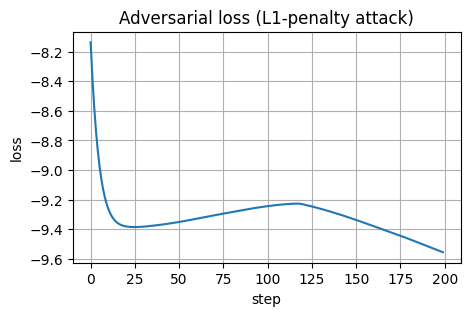

psnr: 7.414632627370794


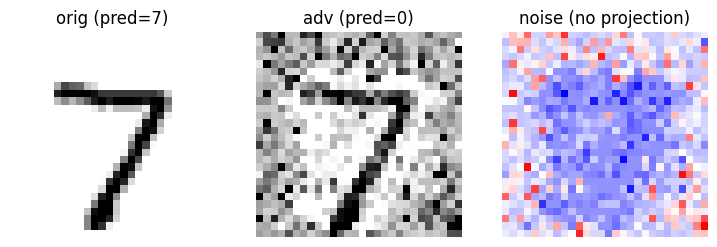

: 

In [ ]:
# print results
pred_before, scores_before = predict_label(model.KS, feature, beta, n, Nc)
pred_after, scores_after   = predict_label(model.KS, x_adv, beta, n, Nc)
print("Before attack: predicted =", int(pred_before), "true =", int(true_label))
print("After attack:  predicted =", int(pred_after),  "true =", int(true_label))
print("Loss (first, last):", losses[0], losses[-1])
print("Mean step time (s):", float(jnp.mean(times)))

# plot loss curve
plt.figure(figsize=(5,3))
plt.plot(losses)
plt.title("Adversarial loss (L1-penalty attack)")
plt.xlabel("step")
plt.ylabel("loss")
plt.grid(True)
plt.show()

# visualize original, adversarial, and noise
orig_img = np.array((feature + 1.0) / 2.0).reshape(28, 28)
adv_img  = np.array((x_adv  + 1.0) / 2.0).reshape(28, 28)
# psnr (peak signal-to-noise ratio) metric
psnr = adv_img.max() / ((orig_img - adv_img) ** 2).mean()
print(f"psnr: {psnr}")
noise_img = np.array(noise).reshape(28, 28)

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(orig_img, cmap='binary')
ax[0].set_title(f"orig (pred={int(pred_before)})")
ax[0].axis('off')
ax[1].imshow(adv_img, cmap='binary')
ax[1].set_title(f"adv (pred={int(pred_after)})")
ax[1].axis('off')
ax[2].imshow(noise_img, cmap='bwr')
ax[2].set_title("noise (no projection)")
ax[2].axis('off')
plt.show()